In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: []


In [3]:
PROCESSED_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\processed\emotions")
MODELS_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

USE_SUBSET = True
SUBSET_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 30
IMG_SIZE = (48, 48)

print(f"Using {'SUBSET' if USE_SUBSET else 'FULL'} dataset")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")


Using SUBSET dataset
Batch size: 64
Epochs: 30


## Load Preprocessed Data

In [5]:
print("Loading preprocessed data...")

X_train = np.load(PROCESSED_DIR / 'X_train.npy')
y_train = np.load(PROCESSED_DIR / 'y_train.npy')
X_val   = np.load(PROCESSED_DIR / 'X_val.npy')
y_val   = np.load(PROCESSED_DIR / 'y_val.npy')
X_test  = np.load(PROCESSED_DIR / 'X_test.npy')
y_test  = np.load(PROCESSED_DIR / 'y_test.npy')

with open(PROCESSED_DIR / 'metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

EMOTION_LABELS = metadata['class_labels']
class_weights_dict = metadata['class_weights']

print(f"\n=== DATA LOADED ===")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Labels: {EMOTION_LABELS}")


Loading preprocessed data...

=== DATA LOADED ===
Train: (24402, 48, 48, 1), Val: (4307, 48, 48, 1), Test: (7178, 48, 48, 1)
Labels: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [6]:
if USE_SUBSET:
    n_train = int(len(X_train) * SUBSET_SIZE)
    n_val = int(len(X_val) * SUBSET_SIZE)

    train_idx = np.random.choice(len(X_train), n_train, replace=False)
    val_idx = np.random.choice(len(X_val), n_val, replace=False)

    X_train, y_train = X_train[train_idx], y_train[train_idx]
    X_val, y_val = X_val[val_idx], y_val[val_idx]

    print(f"\n=== USING SUBSET ===")
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")



=== USING SUBSET ===
Train: 7320, Val: 1292, Test: 7178


## CNN

In [7]:
def build_emotion_cnn(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Dense
        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_emotion_cnn(input_shape=(48, 48, 1), num_classes=len(EMOTION_LABELS))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 128)    │             

 Total params: 2,784,231 (10.62 MB)

 Trainable params: 2,781,799 (10.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
for i, w in class_weights_dict.items():
    print(f"{EMOTION_LABELS[i]:12s}: {w:.3f}")


Model compiled successfully!
angry       : 1.027
disgust     : 9.407
fear        : 1.001
happy       : 0.568
sad         : 0.849
surprise    : 1.293
neutral     : 0.826


## Data Augmentation

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

print(f"Steps per epoch: {len(train_gen)}, Validation steps: {len(val_gen)}")


Steps per epoch: 115, Validation steps: 21


In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    ModelCheckpoint(str(MODELS_DIR / 'emotion_cnn_best.h5'), monitor='val_accuracy',
                    save_best_only=True, verbose=1)
]


## Train Model

In [12]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=0
)



Epoch 1: val_accuracy improved from 0.16409 to 0.17105, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\emotion_cnn_best.h5



Epoch 2: val_accuracy did not improve from 0.17105

Epoch 3: val_accuracy did not improve from 0.17105

Epoch 4: val_accuracy did not improve from 0.17105

Epoch 5: val_accuracy did not improve from 0.17105

Epoch 6: val_accuracy did not improve from 0.17105

Epoch 7: val_accuracy did not improve from 0.17105

Epoch 8: val_accuracy did not improve from 0.17105

Epoch 9: val_accuracy did not improve from 0.17105

Epoch 10: val_accuracy did not improve from 0.17105

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: val_accuracy did not improve from 0.17105

Epoch 12: val_accuracy did not improve from 0.17105

Epoch 13: val_accuracy improved from 0.17105 to 0.24690, saving model to C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\models\emotion_cnn_best.h5



Epoch 14: val_accuracy did not improve from 0.24690

Epoch 15: val_accuracy did not improve from 0.24690

Epoch 16: val_accuracy did not improve from 0.24690

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 17: val_accuracy did not improve from 0.24690

Epoch 18: val_accuracy did not improve from 0.24690

Epoch 19: val_accuracy did not improve from 0.24690

Epoch 20: val_accuracy did not improve from 0.24690

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 21: val_accuracy did not improve from 0.24690
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 13.


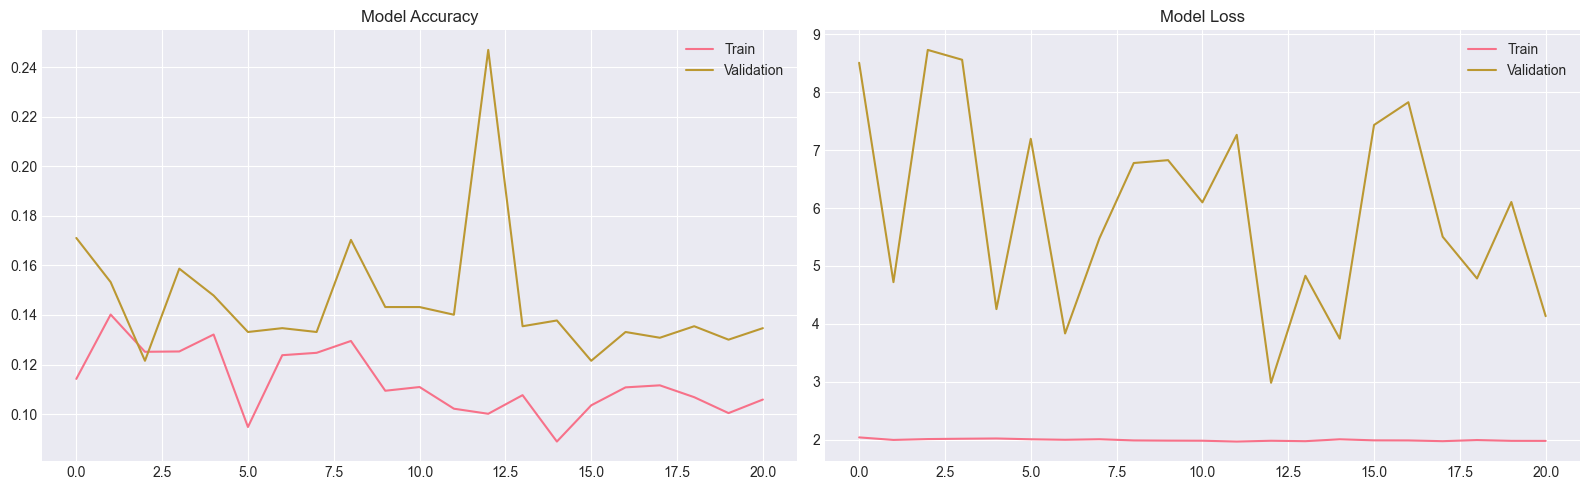

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].plot(history.history['accuracy'], label='Train')
ax[0].plot(history.history['val_accuracy'], label='Validation')
ax[0].set_title("Model Accuracy")
ax[0].legend()

ax[1].plot(history.history['loss'], label='Train')
ax[1].plot(history.history['val_loss'], label='Validation')
ax[1].set_title("Model Loss")
ax[1].legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'training_history.png', dpi=300)
plt.show()


## Evaluate on test data

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=EMOTION_LABELS))


Test Accuracy: 24.64%
              precision    recall  f1-score   support

       angry       0.14      0.02      0.03       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      0.99      0.40      1774
         sad       0.00      0.00      0.00      1247
    surprise       0.10      0.00      0.00       831
     neutral       0.21      0.00      0.00      1233

    accuracy                           0.25      7178
   macro avg       0.10      0.14      0.06      7178
weighted avg       0.13      0.25      0.10      7178



C:\Users\MSI GF66\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI GF66\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI GF66\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

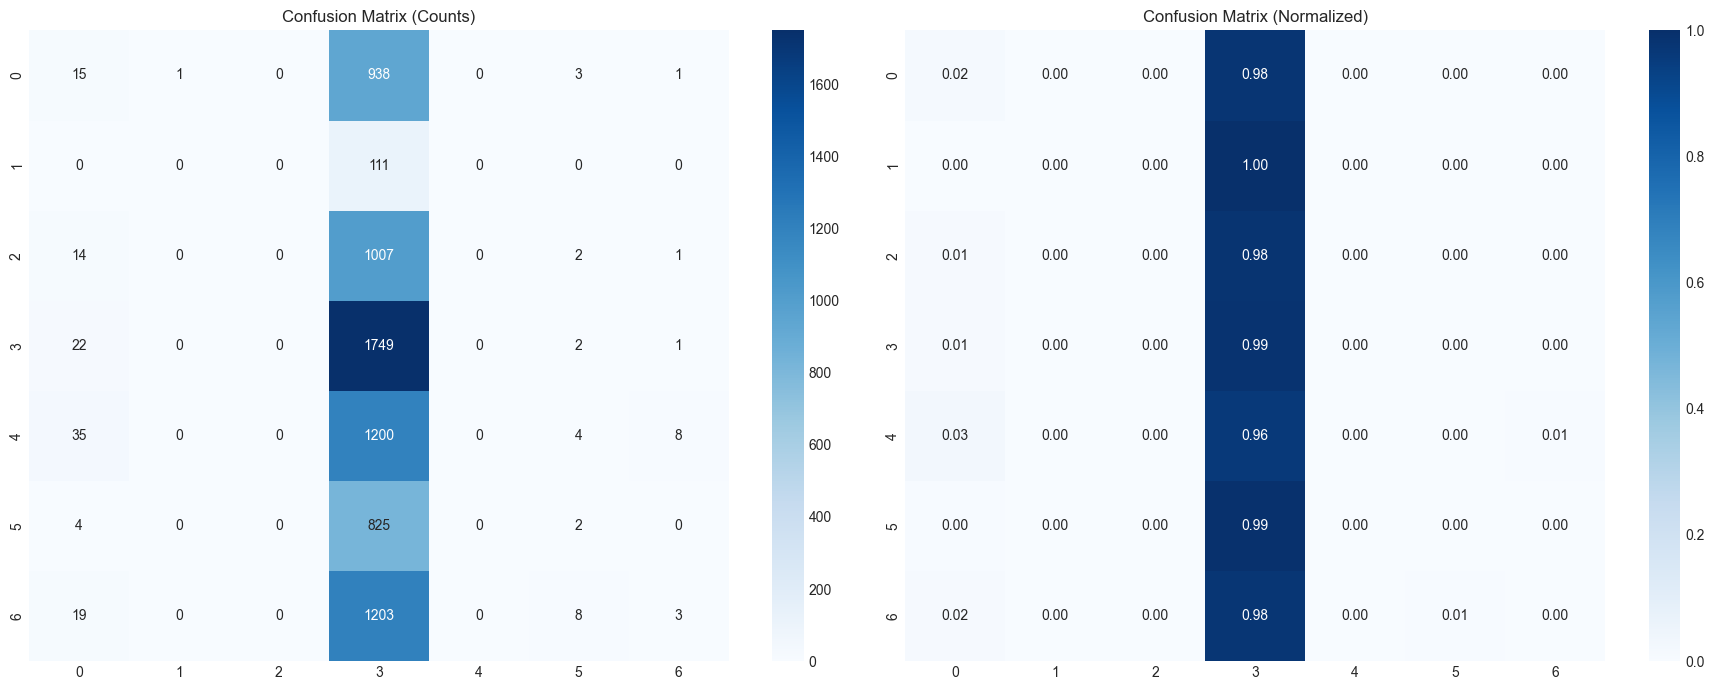

In [15]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18,7))
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0], cmap='Blues')
sns.heatmap(cm_norm, annot=True, fmt='.2f', ax=axes[1], cmap='Blues')

axes[0].set_title("Confusion Matrix (Counts)")
axes[1].set_title("Confusion Matrix (Normalized)")

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrix.png', dpi=300)
plt.show()


In [16]:
acc = cm.diagonal() / cm.sum(axis=1)
acc_df = pd.DataFrame({'Emotion': EMOTION_LABELS, 'Accuracy': acc}).sort_values('Accuracy', ascending=False)
print(acc_df)


    Emotion  Accuracy
3     happy  0.985908
0     angry  0.015658
6   neutral  0.002433
5  surprise  0.002407
1   disgust  0.000000
2      fear  0.000000
4       sad  0.000000


## Save model

In [18]:
model.save(MODELS_DIR / 'emotion_cnn_final.h5')
pd.DataFrame(history.history).to_csv(RESULTS_DIR / 'training_history.csv', index=False)

